In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn
import seaborn as sns

from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/DSO 530 Project"

os.chdir(path)

In [ ]:
data = './option_train.csv'
data = pd.read_csv(data, index_col=0)
data.head()

,Value,S,K,tau,r,BS
1,348.500,1394.46,1050,0.128767,0.0116,Under
2,149.375,1432.25,1400,0.679452,0.0113,Under
3,294.500,1478.90,1225,0.443836,0.0112,Under
4,3.375,1369.89,1500,0.117808,0.0119,Over
5,84.000,1366.42,1350,0.298630,0.0119,Under


In [ ]:
data.shape

(5000, 6)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 1 to 5000
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   5000 non-null   float64
 1   S       5000 non-null   float64
 2   K       5000 non-null   int64  
 3   tau     5000 non-null   float64
 4   r       5000 non-null   float64
 5   BS      5000 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 273.4+ KB


In [ ]:
# check for missing values
data.isnull().sum()

Value    0
S        0
K        0
tau      0
r        0
BS       0
dtype: int64

<Axes: >

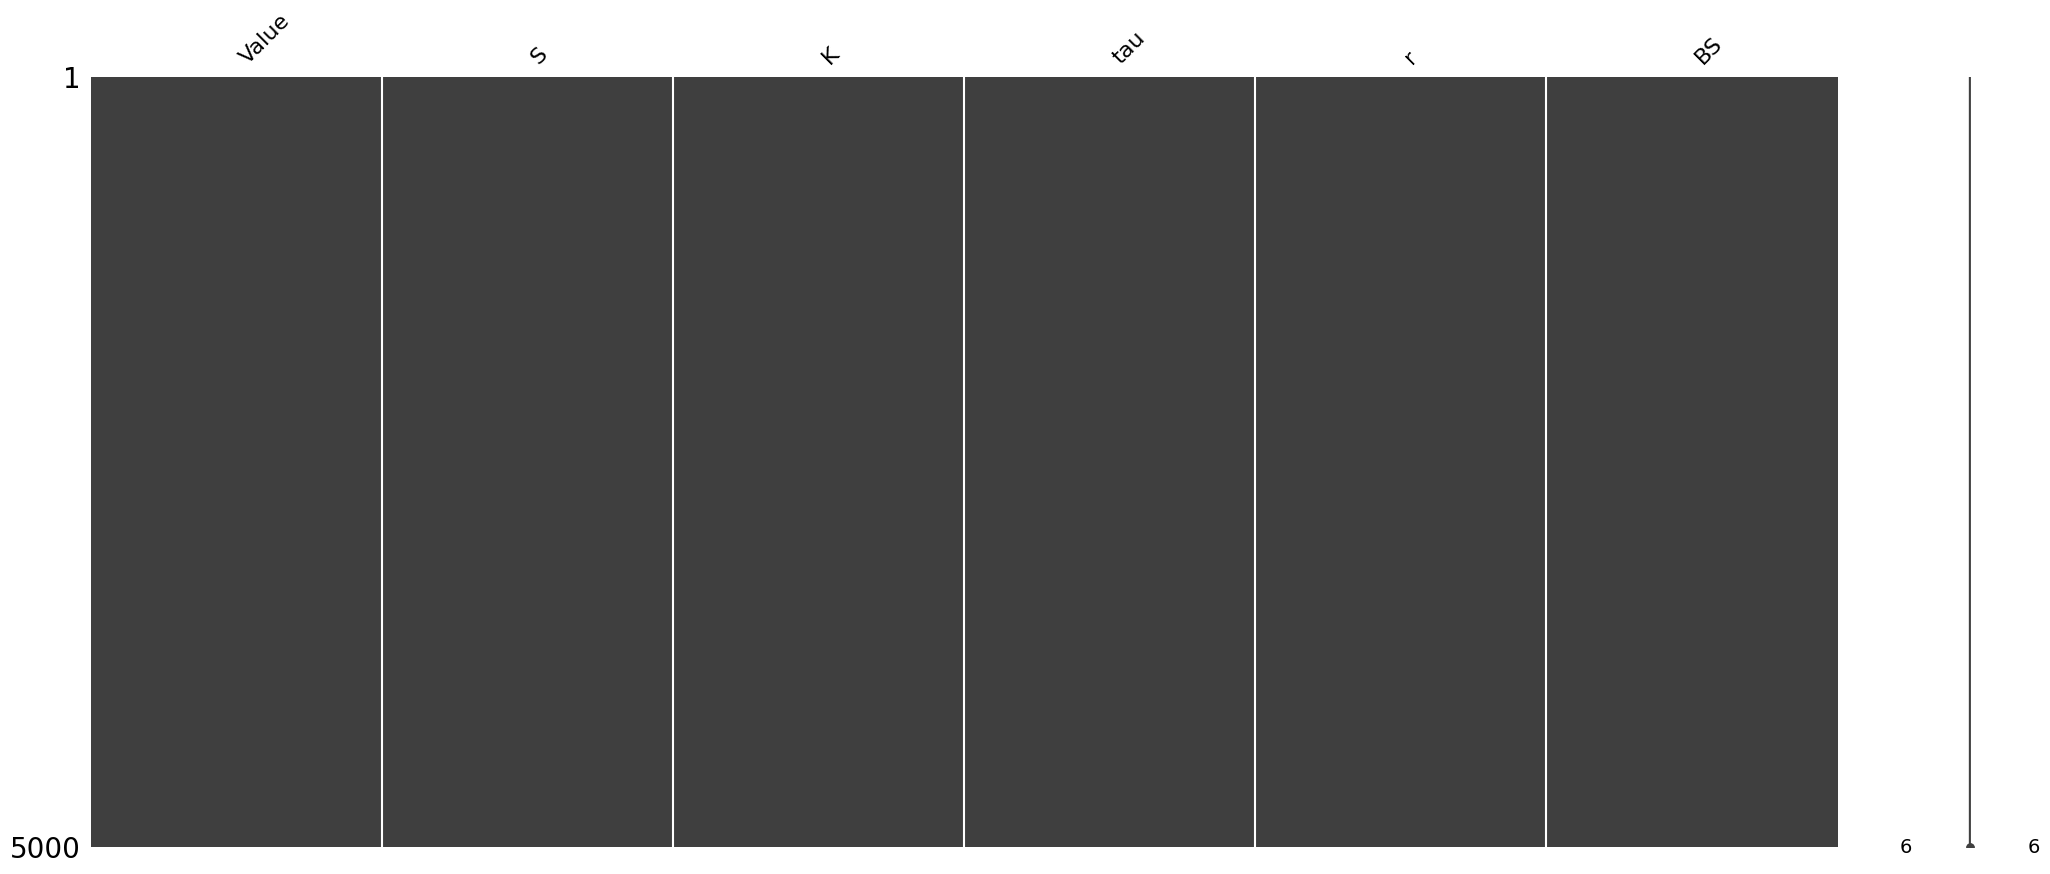

In [ ]:
# visualize data to see if there are missing values
import missingno as msno
msno.matrix(data)
# no missing values found

In [ ]:
# BS: 1	-	“Over” and	0	-	“Under”
data['BS'] = np.where(data['BS']=='Over', 1, 0)
data['BS'].head()

1    0
2    0
3    0
4    1
5    0
Name: BS, dtype: int64

In [ ]:
# checking for correlation between variables
corr_matrix = data.corr()
print(corr_matrix)

          Value         S         K       tau         r        BS
Value  1.000000  0.148884 -0.880802  0.255343 -0.163317 -0.486149
S      0.148884  1.000000  0.128228 -0.020299 -0.983740  0.061290
K     -0.880802  0.128228  1.000000  0.022948 -0.111107  0.537382
tau    0.255343 -0.020299  0.022948  1.000000  0.010245 -0.172979
r     -0.163317 -0.983740 -0.111107  0.010245  1.000000 -0.046926
BS    -0.486149  0.061290  0.537382 -0.172979 -0.046926  1.000000


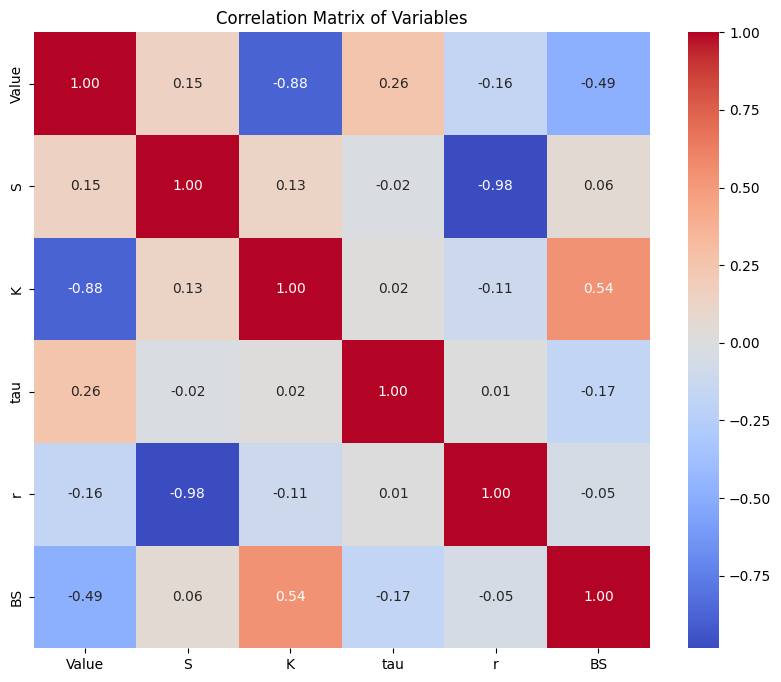

In [ ]:
# heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Variables')
plt.show()


In [ ]:
from sklearn.model_selection import KFold #for regression
from sklearn.model_selection import StratifiedKFold #recommended for classification

kfolds = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
#use k=10 for large datasets
#random_state=1 for reproducibility

print(kfolds)

StratifiedKFold(n_splits=10, random_state=1, shuffle=True)


In [ ]:
cv_classification_errors_1 = []
cv_auc_1 = []

In [ ]:
import statsmodels.formula.api as smf
from sklearn.metrics import roc_curve, auc

for train_index, test_index in kfolds.split(data, data['BS']):
    # Subset the DataFrame directly using .iloc for both train and test splits
    train_subset = data.iloc[train_index]

    # Now fit the model on the train subset
    result = smf.logit(formula='BS ~ S + K', data=train_subset).fit(disp=0)  # Suppressing the output

    # Preparing test data using .iloc for positional indexing
    X_test = data.iloc[test_index][['S', 'K']]
    y_test = data.iloc[test_index]['BS']

    # Compute the probabilities of test data
    result_prob = result.predict(X_test)

    # Select 0.5 as threshold for classification
    result_pred = (result_prob > 0.5)

    # Reshaping result_pred to align with y_test
    result_pred = np.reshape(result_pred.values, y_test.shape)  # Ensuring result_pred is a numpy array for reshape

    # Compute classification error
    classification_error = np.mean(result_pred != y_test)
    cv_classification_errors_1.append(classification_error)

    # Calculate the AUC
    fpr, tpr, thresholds = roc_curve(y_test, result_prob)
    roc_auc = auc(fpr, tpr)
    cv_auc_1.append(roc_auc)

In [ ]:
print('classification errors using 10-fold CV: {} \n'.format(cv_classification_errors_1))
print('mean of classification errors using 10-fold CV: {}\n'.format(np.mean(cv_classification_errors_1)))

classification errors using 10-fold CV: [0.142, 0.166, 0.15, 0.148, 0.162, 0.146, 0.144, 0.134, 0.168, 0.164] 

mean of classification errors using 10-fold CV: 0.1524



In [ ]:
print('auc using 10-fold CV: {}\n'.format(cv_auc_1))
print('mean of auc using 10-fold CV: {}'.format(np.mean(cv_auc_1)))

auc using 10-fold CV: [0.9153803937710092, 0.9143056413070819, 0.9093892204614574, 0.9175984999199652, 0.9167295511193433, 0.905890558185269, 0.898698863506437, 0.9044041983947314, 0.9054972275247705, 0.90404281428961]

mean of auc using 10-fold CV: 0.9091936968479676


This is an excellent performance range, indicating a very high level of discrimination between positive and negative classes.

In [ ]:
cv_classification_errors_2 = []
cv_auc_2 = []

In [ ]:
for train_index, test_index in kfolds.split(data, data['BS']):
  train_subset = data.iloc[train_index]

  #train the logistic model
  result = smf.logit(formula='BS ~ r + tau', data=train_subset).fit(disp=0)  # Suppressing the output

  #selecting the test set according to test_index produced by kfolds.split
  X_test = data.iloc[test_index][['r', 'tau']]
  y_test = data.iloc[test_index]['BS']

  # Compute the probabilities of test data
  result_prob = result.predict(X_test)
  # Select 0.5 as threshold for classification
  result_pred = (result_prob > 0.5)

  # Reshaping result_pred to align with y_test
  result_pred = np.reshape(result_pred.values, y_test.shape)  # Ensuring result_pred is a numpy array for reshape

  # Compute classification error
  classification_error = np.mean(result_pred != y_test)
  cv_classification_errors_2.append(classification_error)

  # Calculate the AUC
  fpr, tpr, thresholds = roc_curve(y_test, result_prob)
  roc_auc = auc(fpr, tpr)
  cv_auc_2.append(roc_auc)

In [ ]:
print('classification errors using 10-fold CV: {}\n'.format(cv_classification_errors_2))
print('mean of classification errors using 10-fold CV: {}'.format(np.mean(cv_classification_errors_2)))

classification errors using 10-fold CV: [0.226, 0.226, 0.226, 0.226, 0.226, 0.226, 0.226, 0.226, 0.228, 0.228]

mean of classification errors using 10-fold CV: 0.22640000000000002


In [ ]:
print('auc using 10-fold CV: {}\n'.format(cv_auc_2))
print('mean of auc using 10-fold CV: {}'.format(np.mean(cv_auc_2)))

auc using 10-fold CV: [0.5896960965905192, 0.6070179049187074, 0.6518716699823923, 0.6360590885184423, 0.6104136653632435, 0.6358761519288376, 0.6547186206581144, 0.5948183210994489, 0.6297950186346696, 0.6416689391873466]

mean of auc using 10-fold CV: 0.6251935476881723


In [ ]:
print('predictor variable: S, K; response variable: BS')
print('mean of classification errors using 10-fold CV: {}'.format(np.mean(cv_classification_errors_1)))
print('mean of auc using 10-fold CV: {}\n'.format(np.mean(cv_auc_1)))
print('predictor variable: r, tau; response variable: BS')
print('mean of classification errors using 10-fold CV: {}'.format(np.mean(cv_classification_errors_2)))
print('mean of auc using 10-fold CV: {}'.format(np.mean(cv_auc_2)))

predictor variable: S, K; response variable: BS
mean of classification errors using 10-fold CV: 0.1524
mean of auc using 10-fold CV: 0.9091936968479676

predictor variable: r, tau; response variable: BS
mean of classification errors using 10-fold CV: 0.22640000000000002
mean of auc using 10-fold CV: 0.6251935476881723


The auc 0.625 is considered poor. It indicates limited ability to discriminate between the positive and negative classes.

CV for models in sklearn

using cross_val_score function in sklearn

default scoring is the accuracy (1-classification error)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logistic_model = LogisticRegression(penalty='none', max_iter=1000)
error_model_1_cv = cross_val_score(logistic_model, data[['S', 'K', 'tau', 'r']], data['BS'], cv=kfolds)
error_model_2_cv = cross_val_score(logistic_model, data[['S', 'K', 'tau', 'r']], data['BS'], cv=kfolds)

print('Logistic Regression: \n')
print('accuracies of 10-folds:', error_model_1_cv, '(mean classification error: ', 1-np.mean(error_model_1_cv), ')')
print('accuracies of 10-folds:', error_model_2_cv, '(mean classification error: ', 1-np.mean(error_model_2_cv), ')')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:11

Logistic Regression: 

accuracies of 10-folds: [0.902 0.87  0.892 0.9   0.89  0.868 0.854 0.888 0.87  0.85 ] (mean classification error:  0.12159999999999993 )
accuracies of 10-folds: [0.902 0.87  0.892 0.9   0.89  0.868 0.854 0.888 0.87  0.85 ] (mean classification error:  0.12159999999999993 )


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [ ]:
logistic_model = LogisticRegression(penalty=None, max_iter=10000)
error_model_1_cv = cross_val_score(logistic_model, data[['S', 'K']], data['BS'], cv=kfolds, scoring='accuracy')
error_model_2_cv = cross_val_score(logistic_model, data[['S', 'K']], data['BS'], cv=kfolds, scoring='accuracy')

print('Logistic Regression: \n')
print('accuracies of 10-folds: ', error_model_1_cv, '(mean classification error: ',1-np.mean(error_model_1_cv), ')' )
print('accuracies of 10-folds: ', error_model_2_cv, '(mean classification error: ',1-np.mean(error_model_2_cv), ')' )

Logistic Regression: 

accuracies of 10-folds:  [0.836 0.818 0.818 0.83  0.848 0.82  0.82  0.82  0.798 0.836] (mean classification error:  0.17559999999999998 )
accuracies of 10-folds:  [0.836 0.818 0.818 0.83  0.848 0.82  0.82  0.82  0.798 0.836] (mean classification error:  0.17559999999999998 )


In [ ]:
logistic_model = LogisticRegression(penalty=None, max_iter=10000)
error_model_1_cv = cross_val_score(logistic_model, data[['tau', 'r']], data['BS'], cv=kfolds, scoring='accuracy')
error_model_2_cv = cross_val_score(logistic_model, data[['tau', 'r']], data['BS'], cv=kfolds, scoring='accuracy')

print('Logistic Regression: \n')
print('accuracies of 10-folds: ', error_model_1_cv, '(mean classification error: ',1-np.mean(error_model_1_cv), ')' )
print('accuracies of 10-folds: ', error_model_2_cv, '(mean classification error: ',1-np.mean(error_model_2_cv), ')' )

Logistic Regression: 

accuracies of 10-folds:  [0.774 0.774 0.774 0.774 0.774 0.774 0.774 0.774 0.772 0.772] (mean classification error:  0.22639999999999993 )
accuracies of 10-folds:  [0.774 0.774 0.774 0.774 0.774 0.774 0.774 0.774 0.772 0.772] (mean classification error:  0.22639999999999993 )


# **Decision Trees**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [ ]:
X = data[['S', 'K', 'tau', 'r']]
y = data['BS']

# Split data into training+validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
clf = DecisionTreeClassifier(random_state=0)

# Set up the parameter grid
param_grid = {
    'max_depth': np.arange(1, 15),
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3],
    'min_impurity_decrease': [0.0, 0.005, 0.01]
}

In [ ]:
# Initialize GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best parameters found: {grid_search.best_params_} with cross-validated accuracy: {grid_search.best_score_:.3f}")

# Retrain the final model on the entire training data with the best parameters
clf_final = DecisionTreeClassifier(random_state=0, **grid_search.best_params_)
clf_final.fit(X_train, y_train)

Best parameters found: {'max_depth': 11, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 2} with cross-validated accuracy: 0.909


DecisionTreeClassifier(max_depth=11, min_samples_leaf=3, random_state=0)

In [ ]:
# Evaluate the final model on the test set
y_pred_test = clf_final.predict(X_test)
score_test = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {score_test:.3f}")
classification_error = 1 - score_test
print(f"Classification Error: {classification_error:.3f}")

Test Accuracy: 0.895
Classification Error: 0.105


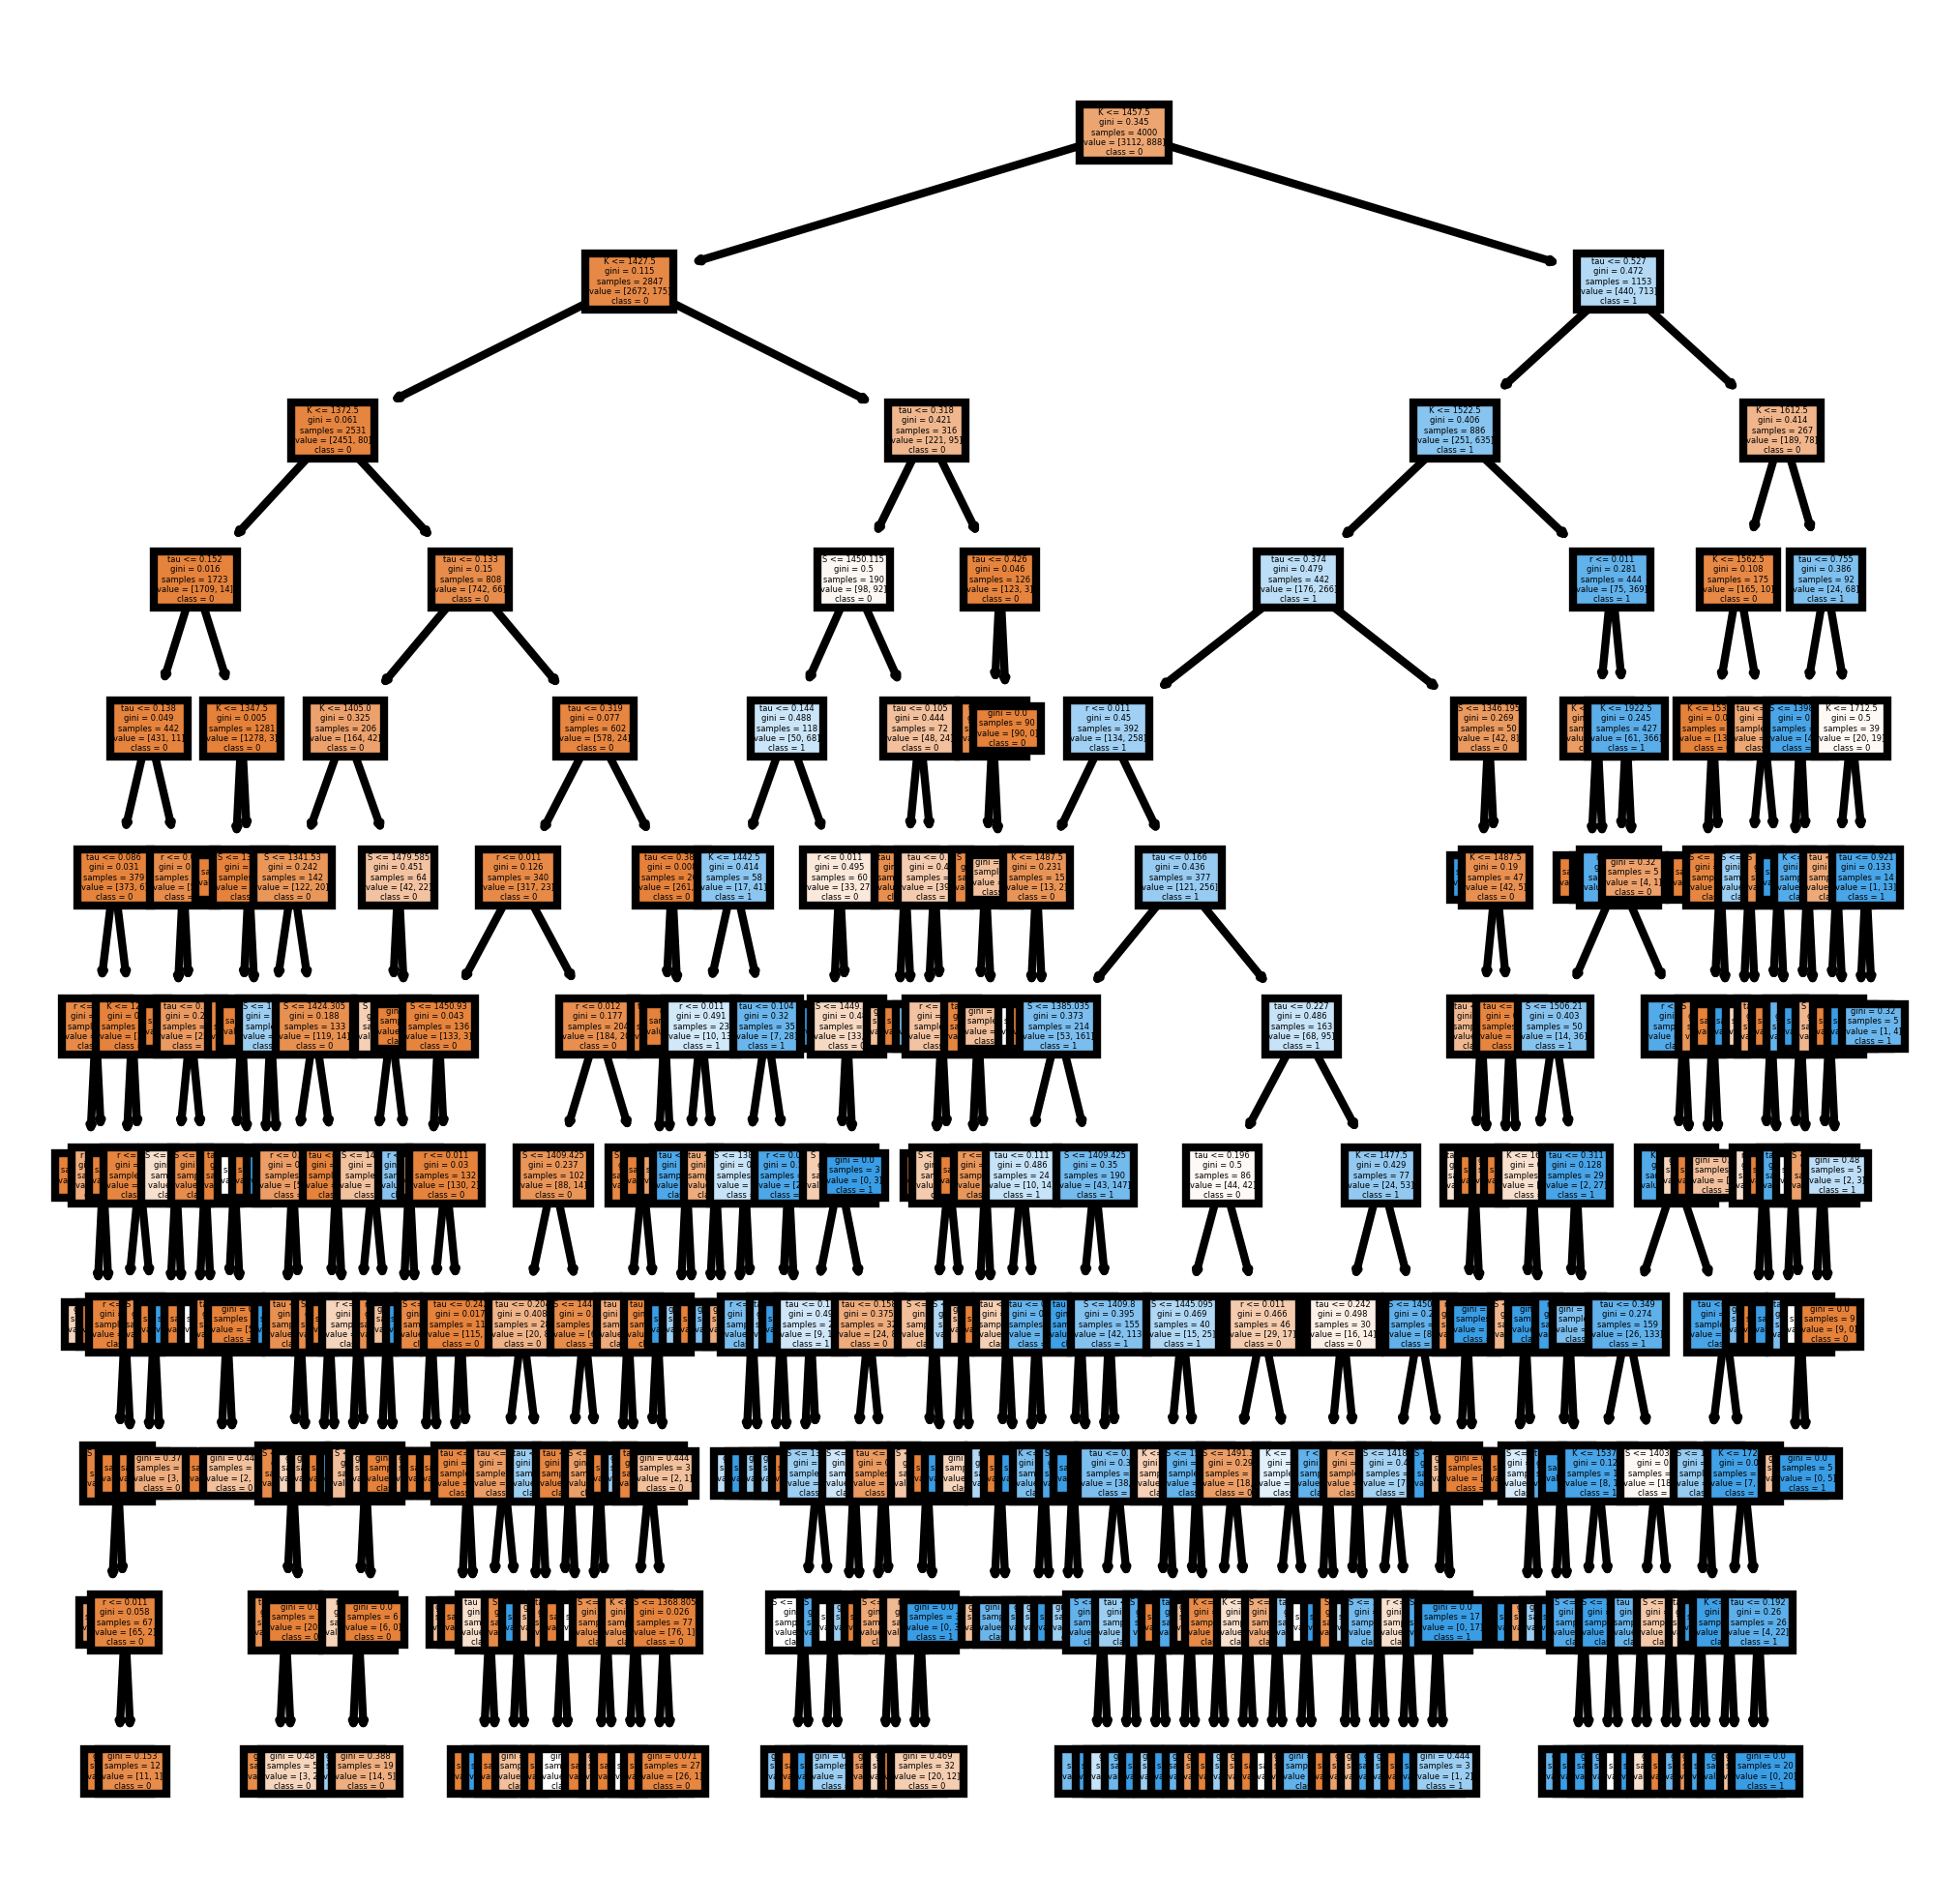

In [ ]:
# Plot the tree
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,4), dpi=600)
plot_tree(clf_final, feature_names=list(X_train.columns), class_names=['0', '1'], filled=True, ax=axes)
plt.show()

# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
X = data[['S', 'K', 'tau', 'r']]
y = data['BS']

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the RandomForest model
rf = RandomForestClassifier(random_state=0)

In [ ]:
# Define hyperparameters grid to test
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [ ]:
# Best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Cross-Validated Accuracy: 0.9307500000000001


In [ ]:
# Retrain the model on the entire training set with the best parameters
rf_best = grid_search.best_estimator_
rf_best.fit(X_train, y_train)  # Using the entire train data for training

# Final evaluation on the test set
y_test_pred = rf_best.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.3f}")
classification_error = 1 - test_accuracy
print(f"Classification Error: {classification_error:.3f}")


Test Accuracy: 0.930
Classification Error: 0.070


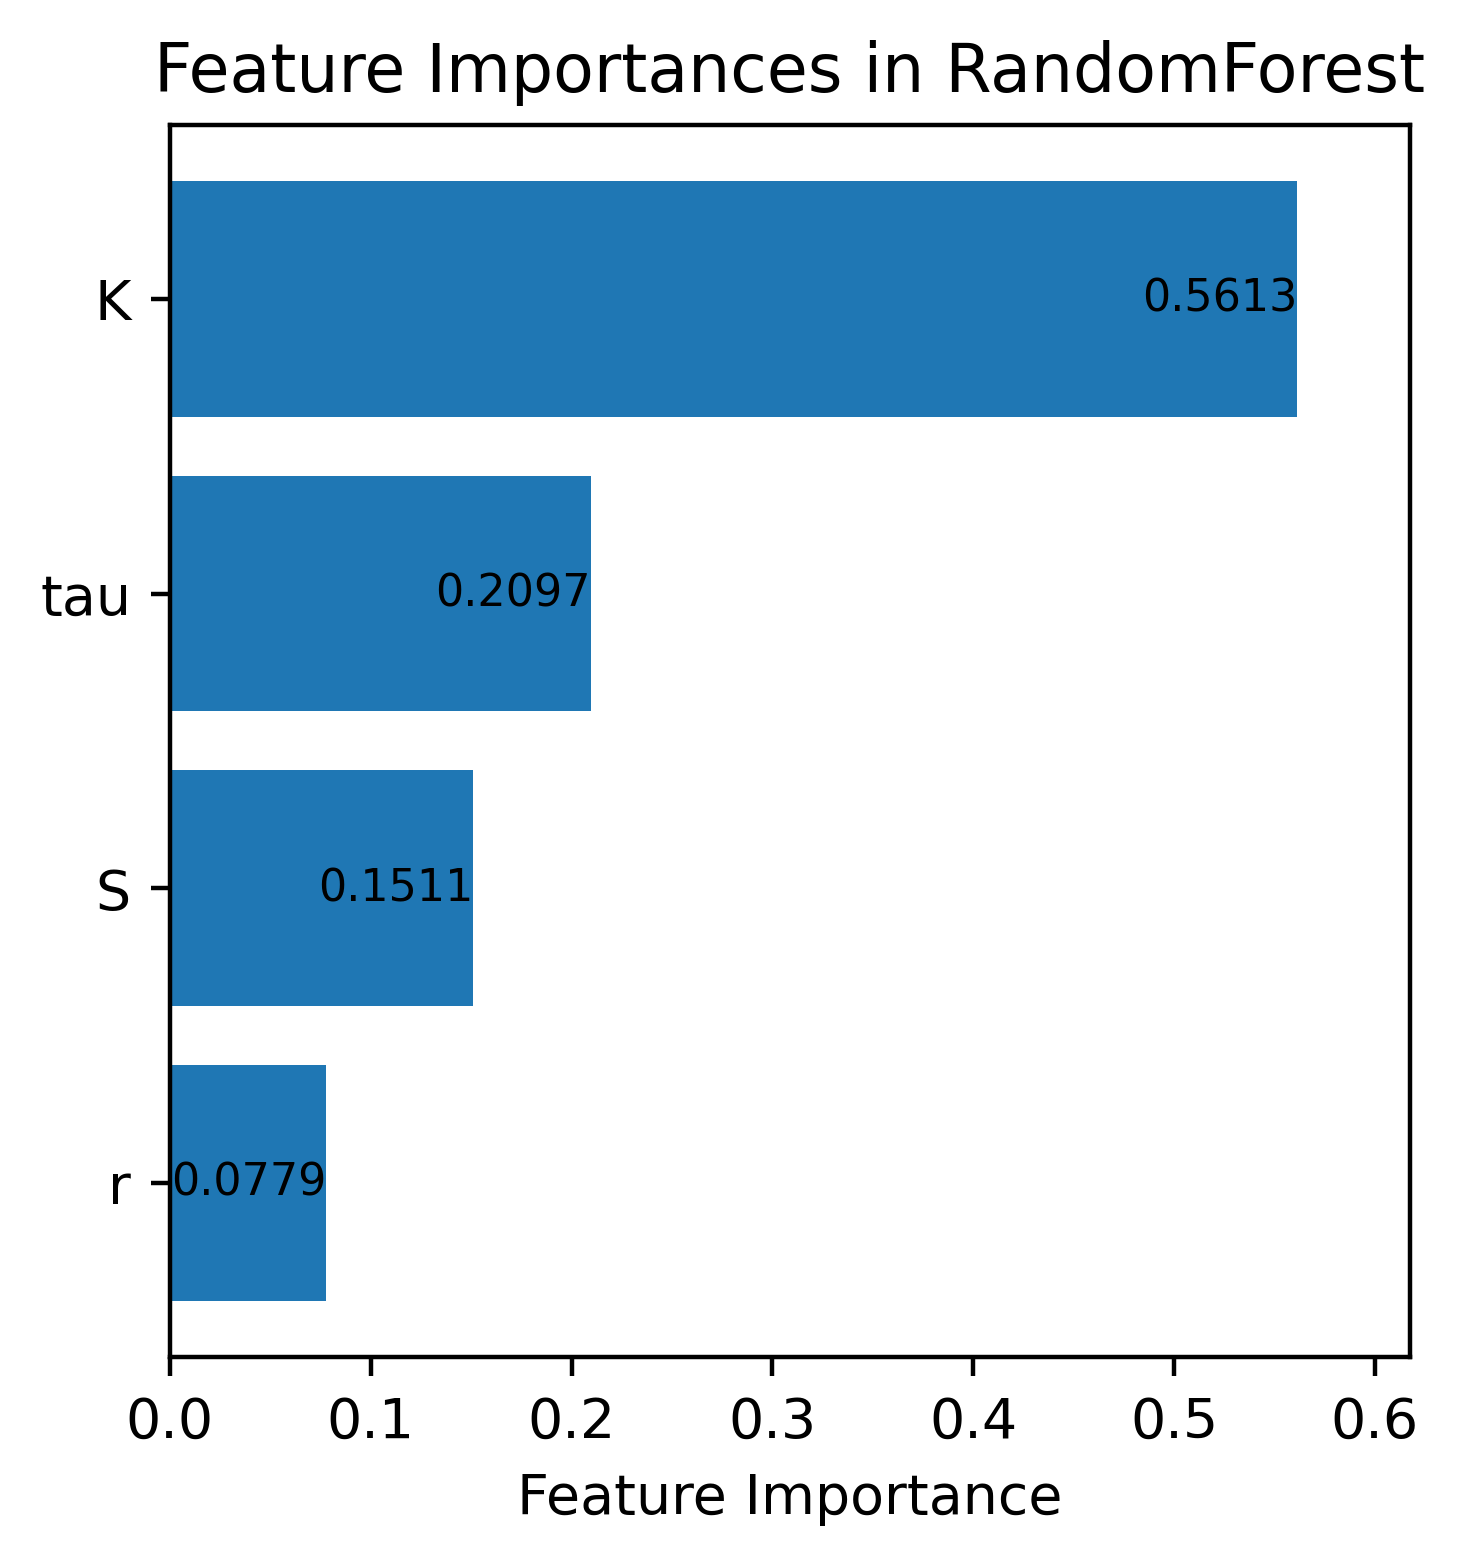

In [ ]:
# Plot feature importances
features = X.columns
importances = rf_best.feature_importances_
sorted_idx = np.argsort(importances)

fig, ax = plt.subplots(figsize=(4, 4), dpi=400)
bars = ax.barh(np.array(features)[sorted_idx], importances[sorted_idx])
ax.set_xlabel("Feature Importance")
ax.set_title("Feature Importances in RandomForest")

for bar, value in zip(bars, importances[sorted_idx]):
    text = f'{value:.4f}'
    x_position = bar.get_width()
    y_position = bar.get_y() + bar.get_height() / 2
    ax.text(x_position, y_position, text, va='center', ha='right', color='black', fontsize=8)

ax.set_xlim(0, max(importances[sorted_idx]) * 1.1)  # extend x-axis limit to make room for labels

plt.show()


# **Support Vector Machine**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
X = data[['S', 'K', 'tau', 'r']]
y = data['BS']

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training+validation and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a pipeline to scale data and train an SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=42))
])

# Define the hyperparameter grid
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': [0.001, 0.01, 0.1, 1],
    'svm__kernel': ['rbf', 'linear']
}

# linear - simplest, works when data is linearly separable
# rbf - more flexible, can model non-linear boundaries, often default in svm applications

In [ ]:
# Find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_val, y_train_val)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC(random_state=42))]),
             param_grid={'svm__C': [0.1, 1, 10],
                         'svm__gamma': [0.001, 0.01, 0.1, 1],
                         'svm__kernel': ['rbf', 'linear']},
             scoring='accuracy', verbose=1)

In [ ]:
# Best model parameters and cross-validation score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

Best parameters found: {'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'rbf'}
Best cross-validation score: 0.916


In [ ]:
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
classification_error = 1 - test_accuracy
print("Test set accuracy: {:.3f}".format(test_accuracy))
print("Classification Error: {:.3f}".format(classification_error))


Test set accuracy: 0.917
Classification Error: 0.083


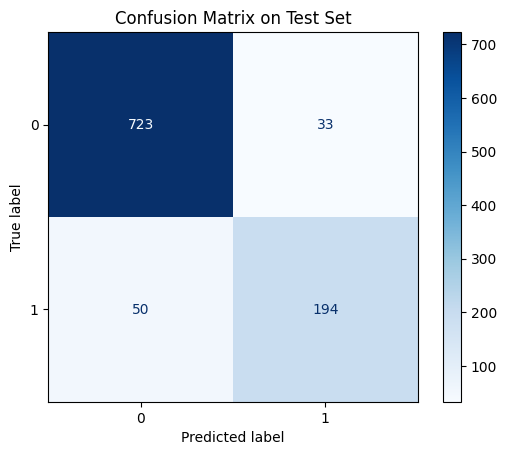

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Test Set')
plt.show()


# **Gradient Boosting Classifier**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import tree


In [ ]:
X = data[['S', 'K', 'tau', 'r']]
y = data['BS']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# Parameter Grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 4, 5]
}

# Model Initialization and Grid Search with 5-fold Cross-Validation
gbm = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [ ]:
# Best model from Grid Search
best_gbm = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Cross-validation results, mean test score
print("Best cross-validation accuracy: {:.3f}".format(grid_search.best_score_))


Best parameters found:  {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}
Best cross-validation accuracy: 0.937


In [ ]:
# Test Set Evaluation
y_test_pred = best_gbm.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.3f}')

# Classification Error on Test Set
classification_error = 1 - test_accuracy
print(f"Classification Error: {classification_error:.3f}")

Test Accuracy: 0.944
Classification Error: 0.056


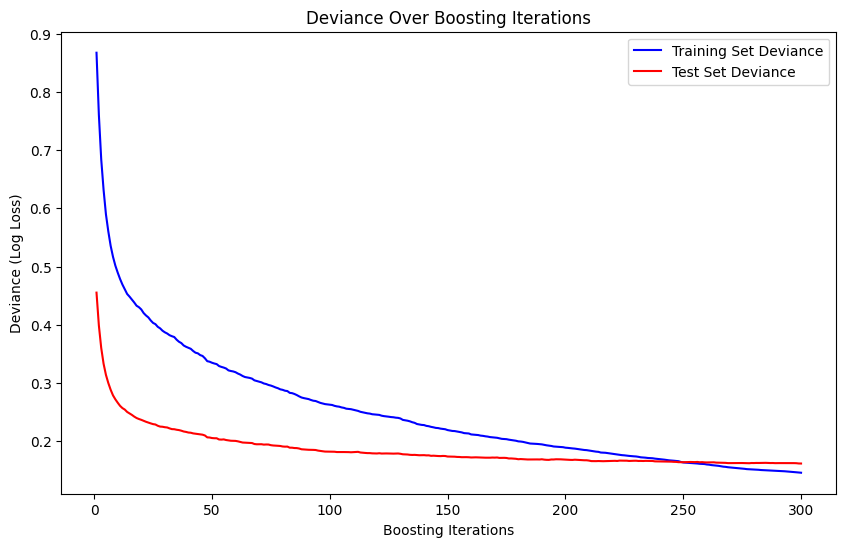

In [ ]:
from sklearn.metrics import log_loss

test_score = np.zeros((best_gbm.n_estimators,), dtype=np.float64)

# Compute the test score for each iteration
for i, y_pred in enumerate(best_gbm.staged_predict_proba(X_test)):
    test_score[i] = log_loss(y_test, y_pred)

# Now plot the training and test loss over iterations
plt.figure(figsize=(10, 6))
plt.title('Deviance Over Boosting Iterations')
plt.plot(np.arange(best_gbm.n_estimators) + 1, best_gbm.train_score_, 'b-', label='Training Set Deviance')
plt.plot(np.arange(best_gbm.n_estimators) + 1, test_score, 'r-', label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance (Log Loss)')
plt.show()

# **Prediction Using Gradient Boosting Classifier**

In [ ]:
# Load the test data
test_data = pd.read_csv('option_test_nolabel.csv')

In [ ]:
test_data.shape

(500, 5)

In [ ]:
test_data.value_counts()

Unnamed: 0  S        K     tau       r     
1           1409.28  1325  0.126027  0.0115    1
330         1455.14  1400  0.087671  0.0111    1
343         1507.08  1450  0.126027  0.0109    1
342         1399.05  1550  0.813699  0.0117    1
341         1398.66  1700  0.876712  0.0117    1
                                              ..
162         1446.23  1600  0.123288  0.0114    1
161         1411.71  1460  0.104110  0.0115    1
160         1457.84  1500  0.279452  0.0112    1
159         1509.98  1550  0.098630  0.0109    1
500         1264.74  1100  0.238356  0.0129    1
Name: count, Length: 500, dtype: int64

In [ ]:
# Scale the test features using the same scaler
X_test_scaled = scaler.transform(test_data[['S', 'K', 'tau', 'r']])

In [ ]:
X_test_scaled

array([[-0.3098159 , -0.26203822, -0.87206382,  0.07226704],
       [ 1.41537668, -1.56516346, -0.0542751 , -1.042965  ],
       [-0.30464157,  0.46192025, -0.56391155,  0.29531344],
       ...,
       [-0.53017093,  0.23025354, -0.7416917 ,  0.51835985],
       [ 0.17603573,  0.60671195,  0.58573347, -0.15077937],
       [-2.88877271, -1.56516346, -0.38613139,  3.19491672]])

In [ ]:
# Use the trained model to predict values for the test set
test_predictions = best_gbm.predict(X_test_scaled)

# Add the predictions to the test data
test_data['BS'] = test_predictions

test_data['BS'].value_counts()

BS
0    398
1    102
Name: count, dtype: int64

In [ ]:
# Save the predictions to a CSV file
test_data[['BS']].to_csv('/content/drive/MyDrive/DSO 530 Project/group_40_prediction_BS.csv', index=False)